In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
#import cartopy.crs as ccrs
from openpyxl import load_workbook
#from shapely.geometry import Point, LineString
#import shapely, shapely.prepared

In [351]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

In [396]:
discountrate = 0.04
NoOfPeakSeason = 2
lengthPeakSeason = 24
NoOfRegSeason = 4
lengthRegSeason = 168
LeapYearsInvestment = 5
season_scale = [(8760 - NoOfPeakSeason * lengthPeakSeason) / NoOfRegSeason / lengthRegSeason
                            for x in range(NoOfRegSeason)] + [1 for x in range(NoOfPeakSeason)]
new_names = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro ror', 'Hydro storage', 'Geothermal']
new_names_2 = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro', 'Geothermal']
old_names = ['Gas CCGT',    'Gas OCGT',  'Bio',   'Oil existing',  'Wind onshore',  'Solar'  ,'Hydro run-of-the-river', 'Hydro regulated', 'Geo']
scenario = '1'
date = '0503'
time = '1122'

file_path = 'Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time + '/results_output_EuropePlot.csv'
operational_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_output_Operational.csv')
investment_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_output_gen.csv')
objective_value = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_objective.csv', header=None)
transmission_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_output_transmision.csv')
stor_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_output_stor.csv')
node_sheet = load_workbook('Data handler/bolivia_v1/Node.xlsx')

scenario_int = int(scenario)
prob_scenarios = {f"scenario{i}": 1/scenario_int for i in range(1,scenario_int+1)}
regular_seasons = ['winter', 'spring', 'summer', 'fall']
peak_seasons = ['peak1', 'peak2']

In [397]:
# Helper functions
def get_colors(carriers):
    colors = [beige2, beige3, green2, beige1, teal4, yellow, teal2, brown2]
    color_dict = dict(zip(new_names_2, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def rename_columns(df):
    old_names_no_space = [names.replace(" ", "") for names in old_names]
    name_map= dict(zip(old_names_no_space, new_names))
    df = df.rename(columns=name_map)
    return df

def open_csv(file, included_rows):
    data_list = []
    with open(file, 'r') as f:
        next(f)
        headers = f.readline().strip().split(',')  # Read the first line to get headers
        for i, line in enumerate(f, start=2):  # Start counting from 2 since headers are at line 1
            if i in included_rows:
                # Split the line by comma, or change delimiter as necessary
                values = line.strip().split(',')
                # Create a dictionary for the row using a dictionary comprehension and zip to pair headers and values
                row_data = dict(zip(headers, values))
                data_list.append(row_data)
    return pd.DataFrame(data_list)

def rename_columns_operations(df):
    operations_names = ['GasCCGT_MW', 'GasOCGT_MW', 'Bio_MW', 'Oilexisting_MW', 'Windonshore_MW', 'Solar_MW', 'Hydrorun-of-the-river_MW', 'Hydroregulated_MW', 'Geo_MW']
    name_map= dict(zip(operations_names, new_names))
    df = df.rename(columns=name_map)
    return df

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_marginal_cost(technology):
    generator_file = load_workbook('Data handler/bolivia_v1/Generator.xlsx')
    generator_efficiency = generator_file['Efficiency']
    generator_VOM = generator_file['VariableOMCosts']
    generator_fuel_cost = generator_file['FuelCosts']

    for row in range(2, generator_efficiency.max_row + 1):  
        if generator_efficiency.cell(row, 1).value == technology:
            efficiency = generator_efficiency.cell(row, 3).value  
            break  

    for row in range(2, generator_VOM.max_row + 1):
        if generator_VOM.cell(row, 1).value == technology:
            VOM = generator_VOM.cell(row, 2).value 
            break

    for row in range(2, generator_fuel_cost.max_row + 1):
        if generator_fuel_cost.cell(row, 1).value == technology:
            fuel_cost = generator_fuel_cost.cell(row, 3).value 
            break
        
    return (3.6/efficiency)*fuel_cost + VOM


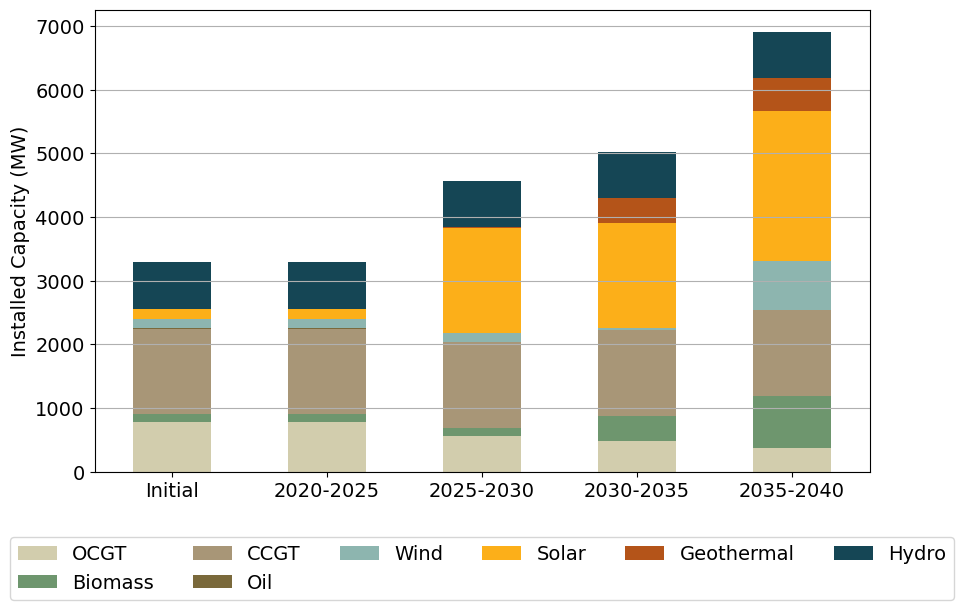

             OCGT    Biomass     CCGT    Oil        Wind        Solar  \
                                                                        
Initial    774.68  127.72000  1343.07  12.00  131.400000   165.080000   
2020-2025  774.68  127.72000  1343.07  12.00  131.400000   165.080000   
2025-2030  559.91  127.72000  1343.07   8.66  131.400000  1648.013146   
2030-2035  474.88  404.01236  1343.07   6.46   27.000000  1643.013146   
2035-2040  369.67  819.00000  1343.07   5.18  773.556313  2360.381635   

             Geothermal       Hydro  
                                     
Initial    0.000000e+00  734.850000  
2020-2025  1.426091e-11  734.850000  
2025-2030  1.498205e+01  732.300000  
2030-2035  4.040767e+02  717.390514  
2035-2040  5.100000e+02  730.566197  


In [398]:
included_rows = [2,3,4,5,6]
installed_cap = open_csv(file_path, included_rows)
installed_cap.set_index('', inplace=True)

for column in installed_cap.columns:
    installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')

installed_cap = rename_columns(installed_cap)
installed_cap['Hydro'] = installed_cap['Hydro ror'] + installed_cap['Hydro storage']
installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

print(installed_cap)

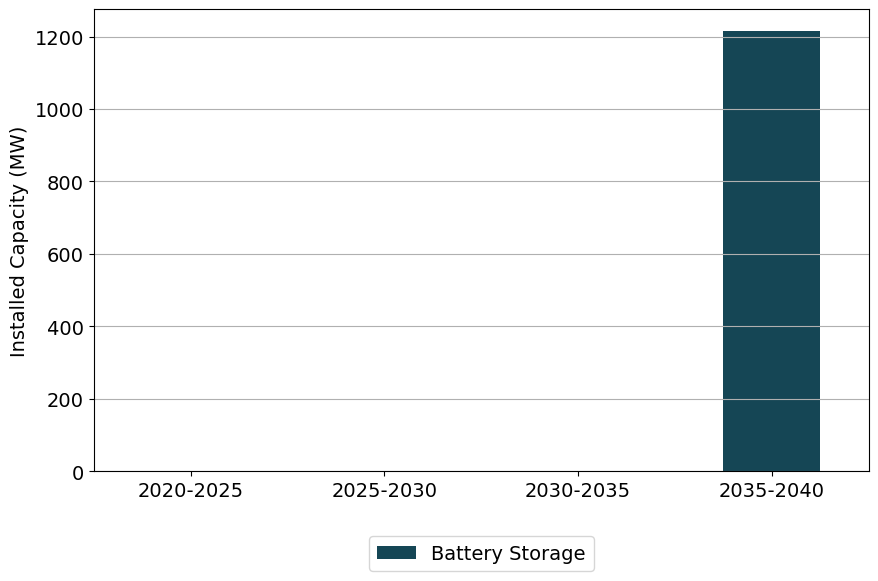

In [399]:
included_rows = [24, 25, 26, 27]
installed_battery = open_csv(file_path, included_rows)
installed_battery.set_index('', inplace=True)

for column in installed_battery.columns:
    installed_battery[column] = pd.to_numeric(installed_battery[column], errors='coerce')

installed_battery.plot(kind='bar', stacked=True, figsize=(10, 6), color=teal2)

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14, labels=['Battery Storage'])
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

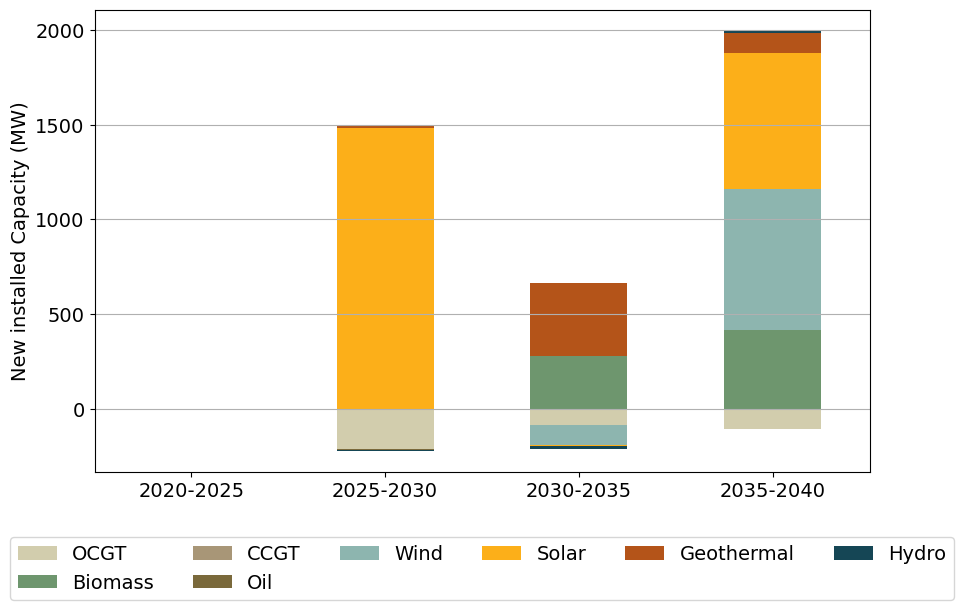

OCGT         -4.050100e+02
Biomass       6.912800e+02
CCGT          1.750777e-11
Oil          -6.820000e+00
Wind          6.421563e+02
Solar         2.195302e+03
Geothermal    5.100000e+02
Hydro        -4.283803e+00
dtype: float64


In [413]:
# New installed capacity
new_installed_cap = installed_cap.diff()
new_installed_cap = rename_columns(new_installed_cap)
# new_installed_cap['Hydro'] = new_installed_cap['Hydro ror'] + new_installed_cap['Hydro storage']
# new_installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
new_installed_cap = new_installed_cap.dropna()
new_installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))

plt.ylabel('New installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
#plt.ylim(0, 1000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/NewInstalledCapacity.png', bbox_inches='tight')
plt.show()

print(new_installed_cap.sum(    ))  

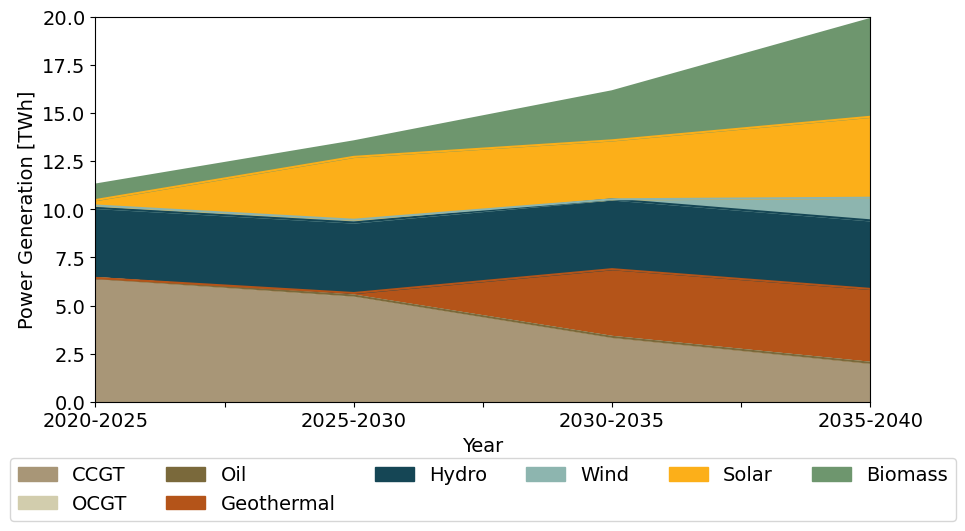

In [412]:
included_rows = [10,11,12,13]

dispatch = open_csv(file_path, included_rows)
dispatch.set_index('', inplace=True)
for column in dispatch.columns:
    dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')

dispatch = rename_columns(dispatch)

dispatch /= 1000
dispatch['Hydro'] = dispatch['Hydro ror'] + dispatch['Hydro storage']
dispatch.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)

# reorder columns to ['CCGT',   'OCGT',  'Oil',  'Geothermal' , 'Hydro', 'Wind', 'Solar',   'Biomass']
dispatch = dispatch[['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]

production_plot = dispatch.plot.area(stacked=True, color=get_colors(dispatch.columns),figsize=(10, 5))
production_plot.set_xlim(0,3)
plt.ylabel('Power Generation [TWh]', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/Production.png', bbox_inches='tight')

C:\Users\marih\AppData\Local\Temp\ipykernel_10700\3037322240.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)


       LoadShed_MW  storCharge_MW      Load_MW    GasCCGT_MW    GasOCGT_MW  \
Hour                                                                         
1     4.103494e-16  -9.809457e-11 -2256.814453  1.051241e+01  2.980344e-11   
2     4.099762e-16  -4.424947e-10 -2396.933404  9.537717e-12  1.091577e-11   
3     4.100864e-16  -2.061231e+01 -2467.375718  7.924108e-12  9.794317e-12   
4     4.102655e-16  -2.429009e+02 -2466.120291  6.466780e-12  8.212358e-12   
5     4.106506e-16  -2.429009e+02 -2466.120291  6.824048e-12  8.611007e-12   

      Oilexisting_MW      Geo_MW  Hydrorun-of-the-river_MW  Windonshore_MW  \
Hour                                                                         
1       3.432998e-12  510.000000                589.828677       82.166109   
2       2.340387e-12  510.000000                556.008402       65.970032   
3       2.168232e-12  510.000000                547.391341      102.866753   
4       1.888558e-12  436.855343                533.087281     

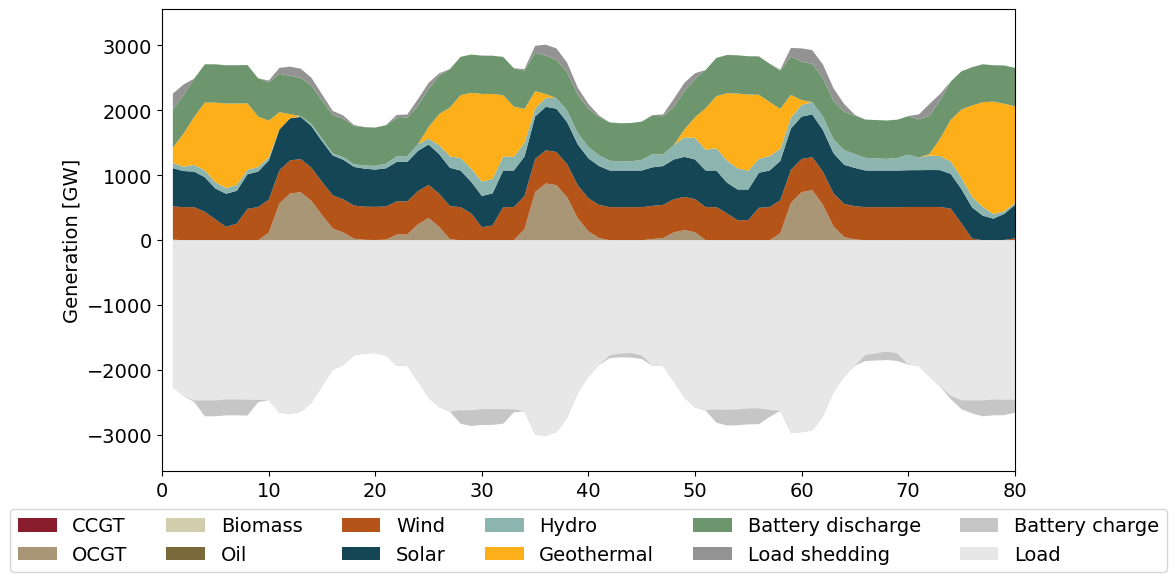

In [428]:
period = '2035-2040'
scenario_number = 'scenario1'

filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(regular_seasons)) & (operational_data['Scenario'] == scenario_number)]
old_names_no_space = [names.replace(" ", "") for names in old_names]
snapshot_columns = [tech + '_MW' for tech in old_names_no_space]
snapshot_columns.append('storDischarge_MW')
snapshot_columns.append('storCharge_MW')
snapshot_columns.append('Hour')
snapshot_columns.append('Load_MW')
snapshot_columns.append('LoadShed_MW')
snapshots = filtered_data[snapshot_columns]
snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)

# Reorder columns to ['Hour', 'LoadShed_MW', 'storCharge_MW', 'storDischarge_MW', 'Load_MW', 'GasCCGT_MW', 'GasOCGT_MW', 'Oilexisting_MW', 'Geo_MW', 'Hydrorun-of-the-river_MW', 'Windonshore_MW', 'Solar_MW', 'Bio_MW']
snapshots = snapshots[['Hour', 'LoadShed_MW', 'storCharge_MW', 'Load_MW', 'GasCCGT_MW', 'GasOCGT_MW', 'Oilexisting_MW', 'Geo_MW', 'Hydrorun-of-the-river_MW', 'Windonshore_MW', 'Solar_MW', 'Bio_MW', 'storDischarge_MW']]

# Sum based on Hour and then plot aggregated snapshots
snapshots = snapshots.groupby('Hour').sum()
print(snapshots.head())
fig, ax=plt.subplots(figsize = (11,6))
columns_to_plot = [col for col in snapshots.columns if col not in ['Hour', 'storCharge_MW', 'Load_MW']]
#colors= [beige2, beige3, green2, beige1, teal4, yellow, teal2, brown2, grey4, red1]
colors = [red1, beige2, beige3, beige1, brown2, teal2, teal4, yellow, green2, grey4]
dispatch_plot = plt.stackplot(snapshots.index, [snapshots[col] for col in columns_to_plot], colors=colors, zorder=2)
plt.stackplot(snapshots.index, snapshots['storCharge_MW'] + snapshots['Load_MW'], labels=['storCharge_MW'], colors=[grey3], zorder=2)
plt.stackplot(snapshots.index, snapshots['Load_MW'], labels=['Load'], colors=[grey1], zorder=2)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
# scale_y = 1e3
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
# ax.yaxis.set_major_formatter(ticks_y)
# myFmt = mdates.DateFormatter('%d %b')
# ax.xaxis.set_major_formatter(myFmt)
all_labels = new_names_2 + ['Battery discharge'] +['Load shedding'] + ['Battery charge'] + ['Load']
plt.legend(labels=all_labels,loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=6, fontsize=14)
ax.set_ylabel('Generation [GW]', fontsize=14)
ax.set_xlim(0, 80)
plt.savefig('figures/Dispatch.png', bbox_inches='tight')

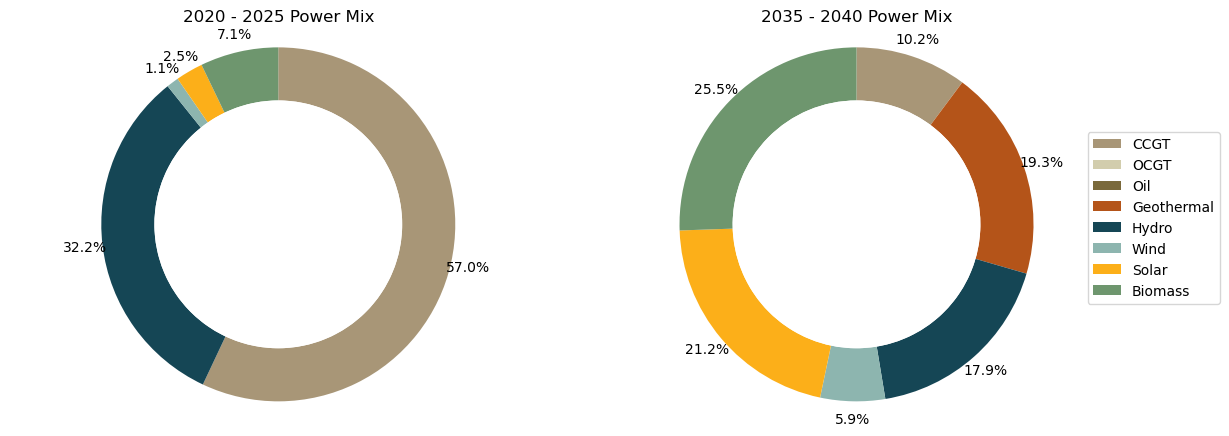

In [429]:
dispatch_firstperiod = dispatch[:1][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
dispatch_lastperiod = dispatch[-1:][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
 
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
 
wedges1, texts1, autotexts1 = ax1.pie(
    dispatch_firstperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_firstperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.1
)
 
wedges2, texts2, autotexts2 = ax2.pie(
    dispatch_lastperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_lastperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.1
)
 
for autotext in autotexts1 + autotexts2:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)
 
centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title("2020 - 2025" +' Power Mix')
 
centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title("2035 - 2040" +' Power Mix')
 
ax1.axis('equal')
ax2.axis('equal')
 
fig.legend(dispatch_lastperiod.columns, loc="center right", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout(pad=3.0)

3790.306503219278


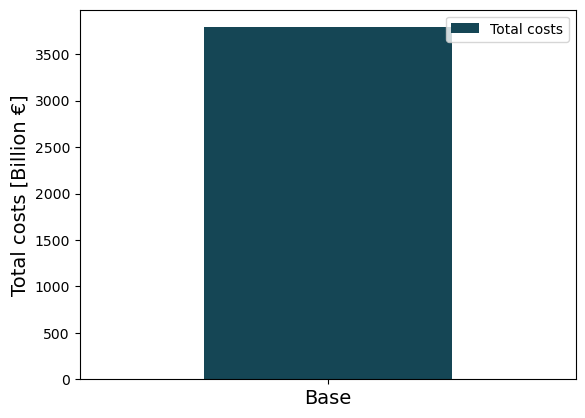

In [404]:
total_costs = objective_value.iloc[0,1] /1e6
total_costs_df = pd.DataFrame(total_costs, index=['Base'],  columns=['Total costs'])
print(total_costs)
total_costs_df.plot(kind='bar', color=teal2)
plt.ylabel('Total costs [Billion €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)

plt.show()

NPV:  3790.3065032193413


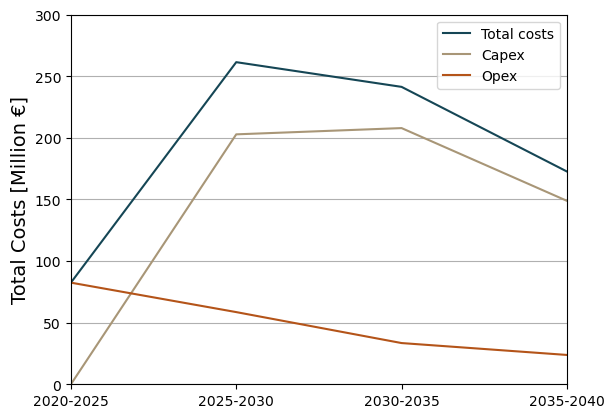

In [405]:
periods = ['2020-2025', '2025-2030', '2030-2035', '2035-2040']
load_shed_cost = node_sheet['NodeLostLoadCost']['C4'].value
capex_dict = {}
for period in periods:
    sum_capex = (investment_data[(investment_data['Period'] == period)]['DiscountedInvestmentCost_Euro'].sum() 
                 + transmission_data[(transmission_data['Period'] == period)]['DiscountedInvestmentCost_EuroPerMW'].sum() 
                 + stor_data[(stor_data['Period'] == period)]['DiscountedInvestmentCostPWEN_EuroPerMWMWh'].sum())
    capex_dict[period] = sum_capex / 1e6 

capex = pd.DataFrame(list(capex_dict.items()), columns=['Period', 'TotalInvestment'])

operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,LeapYearsInvestment)))

opex_dict = {}
for period, num_period in zip(periods, range(1, len(periods) + 1)):
    sum_opex = 0
    coeff = 1
    if num_period > 1:
        coeff = pow(1.0 + discountrate, -LeapYearsInvestment * (num_period - 1))
    for i in range(scenario_int):
        for tech in old_names:
            tech_no_space = tech.replace(" ", "")
            generated = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))][tech_no_space + '_MW'].sum()
            generated_peak = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(peak_seasons))][tech_no_space + '_MW'].sum()
            sum_opex += get_marginal_cost(tech) * (generated * season_scale[0] + generated_peak * season_scale[5]) * prob_scenarios[f'scenario{i+1}'] * coeff * operational_scalar 
        sum_opex += operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))]['LoadShed_MW'].sum() * load_shed_cost * season_scale[0] * prob_scenarios[f'scenario{i+1}'] * coeff * operational_scalar
    
    opex_dict[period] = sum_opex / 1e6 # in billion euros

opex = pd.DataFrame(list(opex_dict.items()), columns=['Period', 'TotalOperationalCost'])
npv = capex['TotalInvestment'].sum() + opex['TotalOperationalCost'].sum()
print('NPV: ', npv)

total_costs = (capex['TotalInvestment'] + opex['TotalOperationalCost']) / 5
plt.plot(periods, total_costs, color=teal2, label ='Total costs')
plt.plot(periods, capex['TotalInvestment'] /5, color=beige2, label='Capex')
plt.plot(periods, opex['TotalOperationalCost'] /5, color=brown2, label = 'Opex')   
plt.ylabel('Total Costs [Million €]', fontsize=14)
plt.xlim(0,3)
plt.ylim(0,300)
plt.grid(axis='y')
plt.legend()
plt.show()


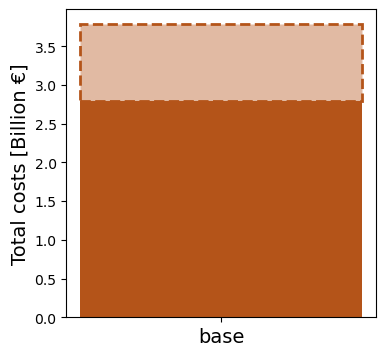

In [406]:
capex_tot = capex['TotalInvestment'].sum() /1e3
opex_tot = opex['TotalOperationalCost'].sum() / 1e3
fig, ax = plt.subplots(figsize=(4, 4))
capex_bars = ax.bar('base', capex_tot, color=brown2)
fill_colors_with_alpha = [mcolors.to_rgba(brown2, alpha=0.4)]
solid_edge_colors = [mcolors.to_rgba(brown2, alpha=1)] 
opex_bars = ax.bar('base', opex_tot, bottom=capex_tot, color=fill_colors_with_alpha, edgecolor=solid_edge_colors, linestyle='--', linewidth=2)


plt.ylabel('Total costs [Billion €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)

plt.show()